In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%pylab inline --no-import-all
BUY = 1
SELL = -1
FUND = int(1000000) #ファンダメンタル価格（実験中は不変で全員共通のためグローバル変数にした）
N_STY = 1000 #スタイライズドトレーダーの数
N_MAKER = 1 #マーケットメイカーの数
DUR = 20000 #注文が自動で取り消されるまでの時間
VOLA = 0.006 
orderVOLA = 30 #スタイライズドトレーダーの発注価格の標準偏差
SPREAD = 0.001 #マーケットメイカーのスプレッド割合



Populating the interactive namespace from numpy and matplotlib


In [2]:
"""
スタイライズドトレーダーのクラス
2市場の場合
市場1は0，市場2は1で表す
"""
class STYLISED(object):

    def __init__(self,ID):
        #randint(a,b)はa~b-1までの整数での一様分布である
        #rand(a,b)はa~bまでの実数での一様分布である
        self.w1 = np.random.rand()*1
        self.w2 = np.random.rand()*10 #重み付け．各上限は先行研究に従った
        self.w3 = np.random.rand()*1
        self.wsum = self.w1 + self.w2 + self.w3
        self.rag = np.random.randint(1,10001) #テクニカル分析時に何期前までまとめて考えるか．1~10000
        self.tech_price = FUND #テクニカル分析時のn期前の価格
        self.price = FUND #直前（1期前）の価格
        self.exprice = FUND #予想される今期の価格
        self.ID = ID
        
    def update_info(self,T,PRICES): 
        """
        情報を得て当期の株価を予想する
        実際にはこの動作の前にグローバル変数PRICESがアップデートされ，その後に行う
        想定ではたとえばT=3，PRICES=[9000,9200,9500],self.rag=4とか
        情報を得るタイミングと注文を出すタイミングに差異があることが予想されるため
        情報取得プロセスと売買決定プロセスは分離した
        """
        self.price = PRICES[-1]
        if T < self.rag: #テクニカル分析の比較対象となる数期前の価格が存在しない場合
            tech_price = FUND
        else:
            tech_price = PRICES[-self.rag]
        fund = self.w1 * (np.log(FUND)-np.log(self.price))
        tech = self.w2 * (np.log(self.price)-np.log(tech_price))
        random = self.w3 * VOLA * np.random.standard_normal()
        self.exprice = self.price * np.exp((fund+tech+random)/self.wsum)
        
    def update_info2(self,T,PRICES1,PRICES2): #2市場が存在する際のモデル 
        """
        情報を得て当期の株価を予想する
        実際にはこの動作の前にグローバル変数PRICESがアップデートされ，その後に行う
        想定ではたとえばT=3，PRICES=[9000,9200,9500],self.rag=4とか
        情報を得るタイミングと注文を出すタイミングに差異があることが予想されるため
        情報取得プロセスと売買決定プロセスは分離した
        """
        self.price = (PRICES1[-1] + PRICES2[-1])/2 #2市場の平均をとる
        if T < self.rag: #テクニカル分析の比較対象となる数期前の価格が存在しない場合
            tech_price = FUND
        else:
            tech_price = (PRICES1[-self.rag] + PRICES2[-self.rag])/2 #こちらも2市場での平均
        fund = self.w1 * (np.log(FUND)-np.log(self.price))
        tech = self.w2 * (np.log(self.price)-np.log(tech_price))
        random = self.w3 * VOLA * np.random.standard_normal()
        self.exprice = self.price * np.exp((fund+tech+random)/self.wsum)

    def decision(self): #売買の決定プロセス
        price = self.exprice + orderVOLA * np.random.standard_normal()
        if self.exprice > price:
            order_price = int(price)
            return BUY,order_price,self.ID #注文価格が予想価格より高ければ買い
        else:
            order_price = int(price)+1
            return SELL,order_price,self.ID #注文価格が予想価格より安ければ売り，同じ場合はまずないので無視
        """
        注文に対応するものがあった場合の成行注文化に対応させる必要アリ！
        →マーケット側に組み込んだ（マッチングの際に古い注文の価格が優先されるようにした）
        """
        
    def decision2(self,indicate1,indicate2):
        """
        2市場のどちらに注文するかを選択した上で注文する
        引数はMARKETクラスの最良気配提示用の関数で出してきたものを2つ
        形式は以下
        (最良買い気配,最良売り気配)
        """
        switch = 0
        order = self.decision() #(BUYorSELL,price,ID)
        if order[0] == BUY: #注文がBUYなので見るのは最良売り気配
            if indicate1[1] < order[1]: #市場1に自分の注文より安く売る相手がいる
                switch += 1
            if indicate2[1] < order[1]: #market2
                switch += 2
        else: #SELL
            if indicate1[0] > order[0]: #市場1に自分の売り注文より高く買う相手がいる
                switch += 1
            if indicate2[0] > order[0]: #market2
                switch += 2
        if switch == 0:
            market = np.random.randint(0,2) # 0 or 1
        elif switch == 1:
            market = 0
        elif switch == 2:
            market = 1
        else: #switch ==3
            if order[0] == BUY:
                if indicate1[1] == indicate2[1]:
                    market = np.random.randint(0,2) # 0 or 1
                elif indicate1[1] > indicate2[1]: #market2 indicates lower price to buy
                    market = 1 #market2
                else:
                    market = 0 #market1
            else:
                if indicate1[0] == indicate2[0]:
                    market = np.random.randint(0,2) # 0 or 1
                elif indicate1[0] < indicate2[0]: #market2 indicates higher price to sell
                    market = 1 #market2
                else:
                    market = 0 #market1
        return market,order
                    
        """
        switch
        0 -> どちらも指値なので1/2でランダム
        1 -> 市場1のみ成行なので市場1に出す
        2 -> 市場2のみ成行なので市場2に出す
        3 -> どちらも成行なので価格を比較する
        """
            



In [3]:
#マーケットのクラス
        
class MARKET(object):

    
    def __init__(self):
        self.buy_orders = []
        self.sell_orders = []
        self.history = []
        self.time = 0
        self.prices = [FUND]
        
        
    def receive(self,order): #スタイライズドトレーダーの注文受付
        # order means (buy_or_sell,price,ID)
        AR = (order[1],self.time,order[2]) #価格，注文受付時刻，注文者のID
        if order[0] == BUY:
            self.buy_orders.append(AR)   
        elif order[0] == SELL:
            self.sell_orders.append(AR)   
        else:
            print "ERROR!!"
    
    def sort(self): #注文を価格，時刻の優先順位でソートする
        self.sell_orders.sort(key=lambda x:(x[0],x[1]),reverse = False) 
        #価格，時刻の順で昇順にソートし売り注文の優先順位順に並び替える
        self.buy_orders.sort(key=lambda x:(x[1]),reverse = False)
        self.buy_orders.sort(key=lambda x:(x[0]),reverse = True)
        #価格は降順，時刻は昇順でソートし買い注文の優先順位順に並び替える
        
    def indicate(self): #HFTの注文価格算出用に最良気配を提示する
        self.sort()
        if len(self.buy_orders) ==0:
            buy = FUND
        else:
            buy = self.buy_orders[0][0]
        if len(self.sell_orders) ==0:
            sell = FUND
        else:
            sell = self.sell_orders[0][0]
        return (buy,sell)
    
    def delete_old(self): #注文持続期間DURを過ぎて残っている注文を削除
        self.buy_orders.sort(key=lambda x:(x[1]),reverse = False)
        self.sell_orders.sort(key=lambda x:(x[1]),reverse = False)
        switch = 0
        while(switch==0):
            if len(self.buy_orders)==0:
                switch = 1
            elif self.buy_orders[0][1] <= self.time-DUR:
                self.buy_orders.pop(0)
            else:
                switch = 1
        switch =0
        while(switch==0):
            if len(self.sell_orders)==0:
                switch = 1
            elif self.sell_orders[0][1] <= self.time-DUR:
                self.sell_orders.pop(0)
            else:
                switch = 1
    
    def clear_history(self): #売買履歴の削除，０期以前に注文を貯めて０期に執行した直後に使用
        self.history = []
                
    def execution(self): #毎期行う！
        switch = False
        while(switch==False):
            if len(self.buy_orders)==0:
                switch = True
            elif len(self.sell_orders)==0:
                switch = True
            elif self.buy_orders[0][0] < self.sell_orders[0][0]:
                # 再優先される売買注文同士でも売買が成立しない場合，ということ
                switch = True
            else:
                if self.buy_orders[0][1] < self.sell_orders[0][1]:
                    price = self.buy_orders[0][0]
                elif self.buy_orders[0][1] > self.sell_orders[0][1]:
                    price = self.sell_orders[0][0]
                else: #注文時刻が同時の場合（当期注文したトレーダーとHFT間で売買成立）
                    if self.buy_orders[0][2] < self.sell_orders[0][2]:
                        price = self.sell_orders[0][0]
                    else:
                        price = self.buy_orders[0][0]
                    """
                    トレーダーの注文直後にマーケットメイカー,HFTが注文を行うことを想定したモデルである
                    よって，トレーダーの注文価格を優先すればよい
                    マーケットメイカー,HFTのIDは負値，トレーダーのIDは正値をとらせるためIDが大きい方を優先することで
                    トレーダーの注文価格を優先させたことになる
                    """
                    

                his = (price,self.time,
                       self.buy_orders[0][0],self.buy_orders[0][1],self.buy_orders[0][2],
                       self.sell_orders[0][0],self.sell_orders[0][1],self.sell_orders[0][2])
                #約定価格，注文時刻，買い注文の価格，時刻，ID，売り注文の価格，時刻，ID
                self.history.append(his)
                """
                買い注文の方が先に出されていた場合
                約定価格は先に出されていた買い注文の価格になる
                """
                self.buy_orders.pop(0) #約定した注文を削除
                self.sell_orders.pop(0)
        
        if len(self.history) == 0:
            current_price = FUND # 一度も売買が行われていない場合にはファンダメンタル価格で対応
        else:
            current_price = self.history[-1][0]
        self.prices.append(current_price)
        
    def receive_MAKER(self,buy_price,sell_price,ID): #マーケットメイカーからの注文受付
        check = 0
        ind = 0
        for order in self.buy_orders: #オーダーからマーケットメイカー由来のものを探しだす作業
            if order[2] == ID:
                ind = (self.buy_orders.index(order))
                check = 1
        if check == 1:
            self.buy_orders[ind] = (buy_price,self.time,ID)
        else: #check == 0
            self.buy_orders.append((buy_price,self.time,ID))
        check = 0
        for order in self.sell_orders:
            if order[2] == ID:
                ind = (self.sell_orders.index(order))
                #order = (sell_price,self.time,ID)
                check = 1
        if check == 1:
            self.sell_orders[ind] = (sell_price,self.time,ID)
        else: #check == 0
            self.sell_orders.append((sell_price,self.time,ID))
    def step(self): # increase time
        self.time += 1

    def formata(self): #シミュレーションを最初からやり直す際に使用
        self.time = 1
        self.prices = [FUND]
        
    def writecsv(self,name):
        PRICES = pd.DataFrame(self.prices)
        PRICES.columns = ["PRICE"]  #カラム名を付ける
        ORDERS_B = pd.DataFrame(self.buy_orders)
        ORDERS_B.columns = ["PRICE","TIME","ID"]
        ORDERS_S = pd.DataFrame(self.sell_orders)
        ORDERS_S.columns = ["PRICE","TIME","ID"]
        HISTORY =pd.DataFrame(self.history)
        HISTORY.columns =["PRICE","TIME","BUY_PRICE","BUY_TIME",
                          "BUY_ID","SELL_PRICE","SELL_TIME","SELL_ID"]
        PRICES.to_csv(name+'_prices.csv')
        ORDERS_B.to_csv(name+'_buy_orders.csv')
        ORDERS_S.to_csv(name+'_sell_orders.csv')
        HISTORY.to_csv(name+'_history.csv')

            

In [5]:
#マーケットメイカーのクラス        
class MAKER(object):
    def __init__(self,ID,spread):#ここのスプレッドはファンダメンタル価格に比した割合，今回は0.1%(0.001)を予定
        self.ID = ID #今回は-1で固定するつもり
        self.margin = FUND*spread/2 #ここのスプレッドは価格の大きさ
        
    def order(self,buy,sell): #2引数はMARKETクラスのindicate_priceで出してくるつもり
        center = (buy+sell)/2
        buy_price = int(center - self.margin)
        sell_price = int(center + self.margin)
        #print buy_price,sell_price
        return buy_price,sell_price,self.ID
    def order2(self,indicate1,indicate2): #2市場の情報を組み入れてマーケットメイクを行う場合
        center = (sum(indicate1)+sum(indicate2))/4 #最良買い気配2つ，最良売り気配2つの平均
        buy_price = int(center - self.margin)
        sell_price = int(center + self.margin)
        return buy_price,sell_price,self.ID

In [6]:
#indicate_price => (buy,sell)
class HFT2(): #2市場(銘柄)間でのアービトラージを行うモデル marketクラスのindicate_priceを多用
    def __init__(self,ID):
        self.ID = ID
    def order(self,M1,M2): #M1 = best(buy,sell)in market1 / M2 =best(buy,sell)in market2
        if M1[0] > M2[1]: #市場1の最良買い気配が市場2の最良売り気配より高いので成行注文により2で買って即座に1で売れば裁定可能
            print "get "+str(M1[0]-M2[1])+"!\n"
            return (SELL,M1[0]-1,self.ID),(BUY,M2[1]+1,self.ID) #前者の価格で市場1に売り，後者の価格で市場2に買いの注文を出す
        elif M2[0] > M1[1]: #市場1で買って即座に市場2で売ることで裁定可能
            print "get "+str(M2[0]-M1[1])+"!\n"
            return (BUY,M1[1]+1,self.ID),(SELL,M2[0]-1,self.ID) #市場1に買い，市場2に売り
        else:
            return 0 #この場合はMARKETクラス側の注文受付時に弾く（なかったことにする）ようにする
    #orderは2市場に対する1単位の注文を2つ出すことに注意
        

ここより上：各クラスの設定

ここより下：クラス同士を相互作用させて実験を行う関数の設定

In [7]:
def storage(market,traders,TIMES): 
    #板寄せで注文を貯める作業．MARKETクラスを持つ引数,STYLISEDクラスのリスト,繰り返し回数を指定する
    #1市場用
    market.time = -len(traders)*TIMES
    for i in range(TIMES):
        for trader in traders:
            trader.update_info(market.time,market.prices)
            order = trader.decision()
            market.receive(order)
            market.step()
    #この段階でT=0のはず
    market.sort() #注文を価格順にソートして
    market.execution() #執行
    market.clear_history() #マッチングした注文は履歴に記録されるが，必要ないので削除
    market.step() #T=1にして終わり

In [8]:
def storage2(mars,traders,times): # storage orders on 2markets
    for i in range(2):
        mars[i].time = -len(traders)*times
    for i in range(times):
        for trader in traders:
            for j in range(2):
                trader.update_info(mars[j].time,mars[j].prices)
                order = trader.decision()
                mars[j].receive(order)
                mars[j].step()
    for mar in mars:
        mar.sort()
        mar.execution()
        mar.clear_history()
        mar.step()

In [9]:
def SIM_STY(market,traders,TIMES): #マーケットメイカーのいない1市場連続時間ダブルオークション
    for i in range(TIMES):
        for trader in traders:
            market.delete_old()
            trader.update_info(market.time,market.prices)
            order = trader.decision()
            market.receive(order)
            market.sort()
            market.execution()
            market.step()

In [10]:
def SIM_STY2(mars,traders,TIMES): #2市場でマーケットメイカーのいない連続時間ダブルオークション
    global T
    for i in range(TIMES):
        for trader in traders:
            for mar in mars:
                mar.delete_old()
            trader.update_info2(mars[0].time,mars[0].prices,mars[1].prices)
            market,order = trader.decision2(mars[0].indicate(),mars[1].indicate())
            mars[market].receive(order)
            mars[market].sort()
            for mar in mars:
                mar.execution()
                mar.step()

In [11]:
def SIM_MAKER(market,traders,maker,TIMES): #マーケットメイカーのいる1市場連続時間ダブルオークション
    global T
    for i in range(TIMES):
        for trader in traders:
            market.delete_old()
            trader.update_info(mar.time,mar.prices)
            order = trader.decision()
            market.receive(order)
            market.sort()
            market.execution()
            m_price = market.indicate()
            m_buy,m_sell,m_ID = maker.order(m_price[0],m_price[1])
            market.receive_MAKER(m_buy,m_sell,m_ID)
            market.step()

In [17]:
def SIM_MAKER2(mars,traders,maker,TIMES): #マーケットメイカーのいる2市場
    m_price = [(FUND,FUND),(FUND,FUND)]
    for i in range(TIMES):
        for trader in traders:
            for mar in mars:
                mar.delete_old()
            trader.update_info2(mars[0].time,mars[0].prices,mars[1].prices)
            market,order = trader.decision2(mars[0].indicate(),mars[1].indicate())
            mars[market].receive(order)
            mars[market].sort()
            for mar in mars:
                mar.execution()
            m_buy,m_sell,m_ID = maker.order2(mars[0].indicate(),mars[1].indicate())
            for mar in mars:
                mar.receive_MAKER(m_buy,m_sell,m_ID)
                mar.step()

In [12]:
def ALL2(mars,traders,maker,hft,TIMES): #マーケットメイカーおよび裁定HFTのいる2市場
    m_price = [(FUND,FUND),(FUND,FUND)]
    M1 = 0
    M2 = 0
    for i in range(TIMES):
        for trader in traders:
            for mar in mars:
                mar.delete_old()
            trader.update_info2(mars[0].time,mars[0].prices,mars[1].prices)
            market,order = trader.decision2(mars[0].indicate(),mars[1].indicate())
            mars[market].receive(order)
            mars[market].sort()
            for mar in mars:
                mar.execution()
            M1 = mars[0].indicate()
            M2 = mars[1].indicate()
            orders = hft.order(M1,M2)
            if orders != 0:
                for j in range(2):
                    mars[j].receive(orders[j])
                    mars[j].sort()
                    mars[j].execution()
            m_buy,m_sell,m_ID = maker.order2(mars[0].indicate(),mars[1].indicate())
            for mar in mars:
                mar.receive_MAKER(m_buy,m_sell,m_ID)
                mar.time += 1
            M1 = mars[0].indicate()
            M2 = mars[1].indicate()
            orders = hft.order(M1,M2)
            if orders != 0:
                for j in range(2):
                    mars[j].receive(orders[j])
                    mars[j].sort()
                    mars[j].execution()

In [13]:
def move_ave(prices,sums):#移動平均線のプロット用
    kikan = len(prices)-sums
    ave = [0] * kikan
    for i in range(kikan):
        ave[i] = sum(prices[i:sums+i])/sums
        
    plt.plot(ave)
    plt.show

ここから上は関数

ここから下は初期設定および実際の実験に使ったもの

In [30]:
"""
make 1 market, 1000 stylised traders and 1 marketmaker
"""
mar = MARKET()
traders = [STYLISED(i) for i in range(N_STY)]
maker = MAKER(-1,0.001)

In [48]:
"""
make 2 markets, 1000 stylised traders, 1 marketmaker, and 1 arbitrage HFT
"""
mars = [MARKET() for i in range(2)]
traders = [STYLISED(i) for i in range(N_STY)]
maker = MAKER(-1,0.001)
hft = HFT2(-2)

In [31]:
storage(mar,traders,20)

In [42]:
SIM_STY2(mars,traders,20)
mars[0].writecsv('2mar_1_sty_yose_01')
mars[1].writecsv('2mar_2_sty_yose_01')

In [41]:
storage2(mars,traders,20)

In [546]:
SIM_STY(mar,traders,40)
mar.writecsv('1mar_sty_auc_01')

In [543]:
mar.writecsv('1mar_sty_yose_01')

In [32]:
SIM_MAKER(mar,traders,maker,20)
mar.writecsv('1mar_maker_yose_01')

writecsv用の名前ルール

(1)最初に市場の数を書く("1mar_"or"2mar_")

(1.5)市場が2つある場合はどちらの市場のものかを書く("1_"or"2_")

(2)使用したモデルを書く("sty_"or"maker_"or"all_")

(3)注文の貯め方を書く("auc"or"yose")

(4)最後に何回目の実験かを書く("01","02",...)

In [483]:
# マーケットメイカーが関与した約定が全体のうちどのぐらいあるのかを調べたい，後で関数化する
number = 0
marketmaker = 0
for i in mars[1].sell_history:
    if i[2] != 0:
        number += 1
    if i[3] == -1:
        marketmaker += 1
for i in mars[1].buy_history:
    if i[3] == -1:
        marketmaker += 1
print number
print marketmaker

9665
2409


Populating the interactive namespace from numpy and matplotlib


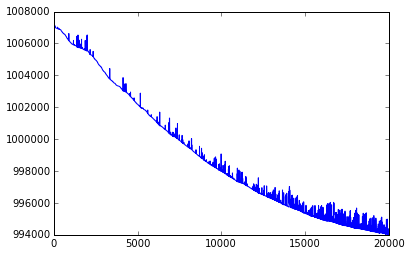

In [487]:
# 価格の動きをプロットしたもの，後で関数化する（PRICESと一緒にMARKETクラスに組み込むのがよいか？）
#plt.ylim(999900, 1000100)
#plt.xlim(7000,8000)
#plt.plot(mars[0].prices)
plt.plot(mar.prices[20000:])
plt.show()


In [22]:
SIM_MAKER2(mars,traders,maker,40)
mars[0].writecsv('2mar_1_maker_auc_01')
mars[1].writecsv('2mar_2_maker_auc_01')

In [176]:
SIM_STY2(mars,traders,10)

In [511]:
import pandas as pd
era = pd.DataFrame(mars[0].buy_orders)
era.columns = ["PRICE","TIME","ID"]  #カラム名を付ける

In [515]:
era.to_csv('2all_1_bu'+'w_orders.csv')

In [507]:
mars[0].buy_orders

[(994019, 33299, 299),
 (994018, 31587, 587),
 (994018, 36270, 270),
 (994017, 29469, 469),
 (994017, 34780, 780),
 (994017, 38410, 410),
 (994013, 36193, 193),
 (994012, 36605, 605),
 (994010, 21933, 933),
 (994009, 26757, 757),
 (994009, 35452, 452),
 (994006, 31143, 143),
 (994006, 31284, 284),
 (994003, 28400, 400),
 (994002, 36992, 992),
 (994002, 37695, 695),
 (993995, 23231, 231),
 (993995, 28876, 876),
 (993994, 30165, 165),
 (993987, 36159, 159),
 (993987, 39712, 712),
 (993986, 28343, 343),
 (993986, 38397, 397),
 (993985, 27878, 878),
 (993985, 38992, 992),
 (993984, 34383, 383),
 (993984, 37747, 747),
 (993984, 39306, 306),
 (993982, 25660, 660),
 (993981, 23564, 564),
 (993981, 25257, 257),
 (993979, 29208, 208),
 (993979, 39177, 177),
 (993977, 37990, 990),
 (993976, 21369, 369),
 (993976, 31051, 51),
 (993974, 24835, 835),
 (993973, 28733, 733),
 (993970, 26243, 243),
 (993967, 33515, 515),
 (993965, 39599, 599),
 (993961, 36759, 759),
 (993960, 35515, 515),
 (993959, 39

In [387]:
for order in mars[0].buy_orders:
    if order[2] == -1:
        print order

(999448, 20000, -1)


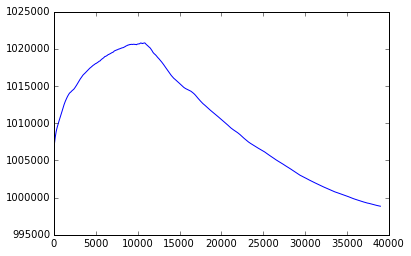

In [51]:
move_ave(mars[1].prices,1000)

Populating the interactive namespace from numpy and matplotlib


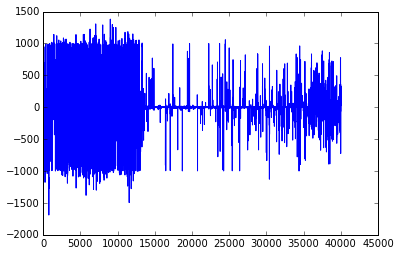

In [52]:
lis = []
for i in range(len(mars[0].prices)):
    lis.append(mars[0].prices[i]-mars[1].prices[i])
%pylab inline --no-import-all
#plt.ylim(-200, 200)

plt.plot(lis)

In [299]:
for order in mar.buy_orders:
    if order[2] == -1:
        print order
        

(999507, 1, -1)


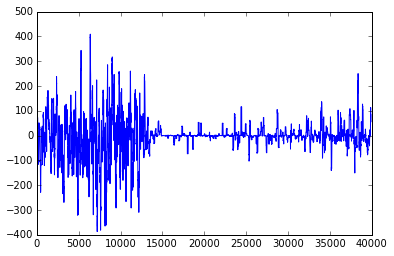

In [53]:
move_ave(lis,100)

In [480]:
mms=[[],[],[],[]]

for history in mars[0].buy_history:
    if history[3] == -2:
        mms[0].append(history)
for history in mars[0].sell_history:
    if history[3] == -2:
        mms[1].append(history)
for history in mars[1].buy_history:
    if history[3] == -2:
        mms[2].append(history)
for history in mars[1].sell_history:
    if history[3] == -2:
        mms[3].append(history)

In [481]:
mms

[[], [], [], []]

In [300]:
# マーケットメイカーが関与した約定が全体のうちどのぐらいあるのかを調べたい，後で関数化する
number = 0
marketmaker = 0
for i in mar.sell_history:
    if i[2] != 0:
        number += 1
    if i[3] == -1:
        marketmaker += 1
for i in mar.buy_history:
    if i[3] == -1:
        marketmaker += 1
print number
print marketmaker

4249
0


In [607]:
mar = MARKET()
traders = [STYLISED(i) for i in range(N_STY)]
makers = [MAKER(-i-1,SPREAD) for i in range(N_MAKER)]  

In [611]:
storage(mar,traders,20)

In [612]:
SIM_STY(mar,traders,5)

In [545]:
#バッチオークション版→お蔵入り
for i in range(100):
    for batch in batches:
        #print [trader.w1,trader.w2,trader.w3]
        #print np.log(FUND/trader.price)
        batch.update_info()
        order = batch.decision()
        #print mar.buy_orders
        #print mar.sell_orders
        #mar.sort_order()
        MAR.receive(order)
        if T%10==0:
            hft = MAR.indicate_price()
            hft_buy,hft_sell,hft_ID = MM.order(hft[0],hft[1])
            MAR.receive_HFT(hft_buy,hft_sell,hft_ID)
            MAR.sort()
            MAR.execution()
            hft = MAR.indicate_price()
            hft_buy,hft_sell,hft_ID = MM.order(hft[0],hft[1])
            MAR.receive_HFT(hft_buy,hft_sell,hft_ID)
        else:
            PRICES.append(MAR.sell_history[-1][0])
        T += 1
        MAR.delete_old()
        
MAR.sort()
"""
for PRICE in PRICES:
    print PRICE
"""

"""
for i in mar.buy_history:
    print i
"""



'\nfor i in mar.buy_history:\n    print i\n'

In [1]:
class HFT(): #ファンダメンタル価格の変更時にマーケットメイカーを出しぬいて利益を得るようなモデル→お蔵入り
    def __init__(self,spread): #ここのスプレッドは新旧のファンダメンタル価格の差に比した割合を示す
        self.old_fund = FUND
        self.new_fund = FUND
        self.spread = spread
        
    def update(self,fundamental):
        self.old_fund = self.new_fund
        self.new_fund = fundamental
    def order(self):
        difference = abs(self.new_fund - self.old_fund)
        center = (self.new_fund+self.old_fund)/2 #新旧のファンダメンタル価格の中央付近での注文を行う
        if difference > 0:
            buy_price = center + diffirence * spread
            sell_price = center + diffirence * spread
            return buy_price,sell_price
        else:
            return self.new_fund *10, 0 #絶対に約定しないような注文を出す，他に状況次第で「注文しない」ような方法があればそちらの方がよい

In [457]:
storage2(mars,traders,100)

In [49]:
ALL2(mars,traders,maker,hft,40)
mars[0].writecsv('2mar_1_all_auc_01')
mars[1].writecsv('2mar_2_all_auc_01')

get 14!

